**GRU**

**数据集：**

采用前13天（13days/30s）没有空缺数据的数据集进行训练和检验

**预测目标：**

超短期预测（4h/15min）的风功率

**可调的参数：**
- 使用前多久的数据进行预测:400
- 数据集的特征: speed power
- 使用多少天的数据进行训练: 6 days
- GRU units 数目: 50
- batch size: 72
- epoch: 100

In [1]:
n = 1
# 使用前400个点的 speed & power 预测接下来 4h(4h/15min) 的power
n_back = 400
n_out = 16
n_pre = n_out*15*2
n_feature = 2
# 使用前6天的数据进行训练
train_len = 8
# 神经网络参数
units = 50
rounds = 100
size = 72

# Preperation

In [7]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

In [3]:
dataset = pd.read_csv('../wind_preprocessed.csv', header=0, index_col=0).query('day<14')

In [4]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


# Training

In [5]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [6]:
# 分割为训练集和测试集
values = reframed.values
n_train_hours = train_len*24*60*2
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)
# 重塑成3D格式 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(23040, 800) (23040, 16)
(13550, 800) (13550, 16)
(23040, 400, 2) (23040, 16) (13550, 400, 2) (13550, 16)


In [8]:
# 设计网络
model = Sequential()
model.add(GRU(units, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_out))

# 拟合神经网络模型
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=rounds, batch_size=size, validation_data=(test_X, test_y), verbose=1, shuffle=False)

2023-01-09 15:38:00.007216: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-09 15:38:00.008250: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 15:38:00.008348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-VC833VJB): /proc/driver/nvidia/version does not exist
2023-01-09 15:38:00.011348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
320/320 [==============================] - 170s 515ms/step - loss: 0.0253 - val_loss: 0.2003
Epoch 2/100
320/320 [==============================] - 174s 543ms/step - loss: 0.0264 - val_loss: 0.1569
Epoch 3/100
320/320 [==============================] - 696s 2s/step - loss: 0.0240 - val_loss: 0.1334
Epoch 4/100
320/320 [==============================] - 165s 517ms/step - loss: 0.0226 - val_loss: 0.1195
Epoch 5/100
320/320 [==============================] - 173s 542ms/step - loss: 0.0217 - val_loss: 0.1108
Epoch 6/100
320/320 [==============================] - 153s 478ms/step - loss: 0.0212 - val_loss: 0.1026
Epoch 7/100
320/320 [==============================] - 141s 440ms/step - loss: 0.0209 - val_loss: 0.0962
Epoch 8/100
320/320 [==============================] - 141s 441ms/step - loss: 0.0205 - val_loss: 0.0923
Epoch 9/100
320/320 [==============================] - 152s 475ms/step - loss: 0.0202 - val_loss: 0.0897
Epoch 10/100
320/320 [==============================] - 16

In [9]:
model.save_weights(f'gru_{n}.h5')

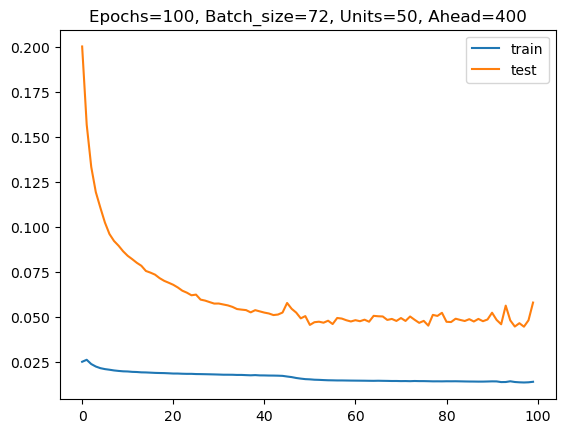

In [11]:
# 绘制历史数据
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title(f'Epochs={rounds}, Batch_size={size}, Units={units}, Ahead=400')
plt.legend()
plt.savefig(f'{n}.png')
plt.show()